# Time Analysis for ICLR LLM Experiments

This notebook analyzes ensemble and calibration times for both mini and full datasets.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import math

In [3]:
# Helper functions
base_path = Path('Ensembling_Finetuned_LLMs')

def read_file(file_path, base_path=base_path) -> pd.DataFrame:
    """
    Read a file and return a DataFrame.
    """
    path = base_path / 'llm_experiments_data' / file_path
    if not path.exists():
        raise FileNotFoundError(f"File {path} does not exist.")
    return pd.read_csv(path)

def compute_stats(df, col):
    """
    Compute mean and std statistics grouped by dataset and ensemble_type.
    """
    stats = (
        df.groupby(['dataset','ensemble_type'])[col]
          .agg(['mean','std'])
          .rename(columns={'mean':'mean_val','std':'std_val'})
    )
    return stats.unstack(level=1)  # gives MultiIndex columns: (mean_val,ensemble), (std_val,ensemble)

In [4]:
# Load the data
df_extended = read_file('llm_experimental_results_extended_iclr_2025-09-14.csv')
df_mini = read_file('llm_experimental_results_mini_iclr_2025-09-14.csv')

print(f"Extended data shape: {df_extended.shape}")
print(f"Mini data shape: {df_mini.shape}")
print(f"\nColumns: {df_extended.columns.tolist()}")

Extended data shape: (191, 13)
Mini data shape: (180, 13)

Columns: ['dataset', 'seed', 'method', 'ensemble_type', 'ensemble_size', 'ensemble_unique_size', 'nll_test', 'c1', 'c2', 'epi_scalar', 'ensemble_time', 'calibration_time', 'path']


In [5]:
# Data preprocessing
method_of_interest = 'pure_logits'

# Filter on method
df_extended = df_extended.loc[df_extended['method'] == method_of_interest].copy()
df_mini = df_mini.loc[df_mini['method'] == method_of_interest].copy()

# Dataset name mapping
dataset_map = {
    'SetFit/mnli': 'SetFit',
    'ag_news': 'News',
    'dbpedia_14': 'DBpedia',
    'imdb': 'IMDB',
    'mteb/tweet_sentiment_extraction': 'Tweet',
    'stanfordnlp/sst2': 'SST-2'
}

df_extended['dataset'] = df_extended['dataset'].replace(dataset_map)
df_mini['dataset'] = df_mini['dataset'].replace(dataset_map)

# Filter for the 6 ensemble types we want
ensemble_types = [
    'greedy_50_baseline', 'greedy_50_temp_baseline', 'greedy_50_post_calib',
    'greedy_unique_5_baseline','greedy_unique_5_temp_baseline', 'greedy_unique_5_post_calib'
]

df_extended = df_extended.loc[df_extended['ensemble_type'].isin(ensemble_types)].copy()
df_mini = df_mini.loc[df_mini['ensemble_type'].isin(ensemble_types)].copy()

# Rename ensemble types for display
etype_map = {
    'greedy_unique_5_baseline': 'Greedy-5 (unique)',
    'greedy_unique_5_temp_baseline': 'Pool-then-calibrate Greedy-5 (unique)',
    'greedy_unique_5_post_calib': 'JUCAL Greedy-5 (unique)',
    'greedy_50_baseline': 'Greedy-50',
    'greedy_50_temp_baseline': 'Pool-then-calibrate Greedy-50',
    'greedy_50_post_calib': 'JUCAL Greedy-50'
}

df_extended['ensemble_type'] = df_extended['ensemble_type'].replace(etype_map)
df_mini['ensemble_type'] = df_mini['ensemble_type'].replace(etype_map)

print(f"Filtered extended data shape: {df_extended.shape}")
print(f"Filtered mini data shape: {df_mini.shape}")
print(f"\nUnique ensemble types: {df_extended['ensemble_type'].unique()}")

Filtered extended data shape: (191, 13)
Filtered mini data shape: (180, 13)

Unique ensemble types: ['Greedy-5 (unique)' 'Greedy-50' 'Pool-then-calibrate Greedy-50'
 'Pool-then-calibrate Greedy-5 (unique)' 'JUCAL Greedy-5 (unique)'
 'JUCAL Greedy-50']


In [6]:
# Plot function adapted for time metrics
def plot_time_metric(
    df_stats,
    ylabel,
    title=None,
    filename=None,
    ylim=None,
    logscale=False,
    order=None,
    ensemble_labels=None,
    colors=None,
    striped_methods=None
):
    """
    Plot time metrics with the same style as the reference notebook.
    """
    n_methods = len(ensemble_labels)

    # Pull out mean/std tables
    df_plot = df_stats['mean_val'][ensemble_labels].copy()
    df_plot_std = df_stats['std_val'][ensemble_labels].copy()

    # Reorder rows if order given
    if order is not None:
        df_plot = df_plot.reindex(order)
        df_plot_std = df_plot_std.reindex(order)
    else:
        df_plot = df_plot.sort_values(by=ensemble_labels[0], ascending=True)
        df_plot_std = df_plot_std.reindex(df_plot.index)

    means = np.vstack([df_plot[lbl].values for lbl in ensemble_labels])
    stds = np.vstack([df_plot_std[lbl].values for lbl in ensemble_labels])

    x = np.arange(len(df_plot)) * 5.5  # Scale the x axis to have space between bars
    width = 0.7

    fig, ax = plt.subplots(figsize=(40,20), dpi=100)
    
    for i, lbl in enumerate(ensemble_labels):
        this_hatch = "/" if lbl in striped_methods else None
        ax.bar(
            x + i*width - (n_methods-1)*width/2,
            means[i],
            width,
            yerr=stds[i],
            capsize=3,
            alpha=1.0,
            color=colors[lbl],
            hatch=this_hatch,
            edgecolor='black' if this_hatch else None,
            label=lbl
        )

    # Logscale
    if logscale:
        ax.set_yscale('log')
        ylabel = ylabel + ' (log scale)'
    
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.set_ylabel(ylabel, fontsize=50)
    ax.set_xticks(x + 0.1)
    ax.set_xticklabels(df_plot.index.tolist(), rotation=0, ha='center', fontsize=50)
    ax.tick_params(axis='y', labelsize=50)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    if title:
        ax.set_title(title, fontsize=55, pad=20)

    # Grab handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Reorder to row-major for a legend with 3 columns
    ncol = 3
    n = len(handles)
    nrows = math.ceil(n / ncol)

    new_order = [
        r * ncol + c
        for c in range(ncol)
        for r in range(nrows)
        if r * ncol + c < n
    ]

    # Apply reordering
    handles = [handles[i] for i in new_order]
    labels = [labels[i] for i in new_order]

    # Place legend underneath
    leg = fig.legend(
        handles, labels,
        ncol=3,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.0),
        framealpha=1,
        borderaxespad=0,
        edgecolor="w",
        fontsize=50
    )

    plt.subplots_adjust(
        left=0.01,
        right=0.99,
        top=0.95,
        bottom=0.18
    )
    
    if filename:
        plt.savefig(filename, dpi=2000, bbox_inches='tight')
    plt.show()

In [7]:
# Plot function with broken y-axis for calibration time
def plot_calibration_time_broken_axis(
    df_stats,
    ylabel,
    title=None,
    filename=None,
    order=None,
    ensemble_labels=None,
    colors=None,
    striped_methods=None,
    break_position=(0.02, 0.5),  # Where to break the axis
    height_ratio=(1, 3)  # Ratio of bottom to top subplot
):
    """
    Plot calibration time with broken y-axis to show both small and large values.
    """
    n_methods = len(ensemble_labels)
    
    # Pull out mean/std tables
    df_plot = df_stats['mean_val'][ensemble_labels].copy()
    df_plot_std = df_stats['std_val'][ensemble_labels].copy()
    
    # Reorder rows if order given
    if order is not None:
        df_plot = df_plot.reindex(order)
        df_plot_std = df_plot_std.reindex(order)
    
    means = np.vstack([df_plot[lbl].values for lbl in ensemble_labels])
    stds = np.vstack([df_plot_std[lbl].values for lbl in ensemble_labels])
    
    x = np.arange(len(df_plot)) * 5.5
    width = 0.7
    
    # Create figure with two subplots
    fig, (ax_top, ax_bottom) = plt.subplots(
        2, 1, 
        figsize=(40, 20), 
        dpi=100,
        sharex=True,
        gridspec_kw={'height_ratios': height_ratio, 'hspace': 0.05}
    )
    
    # Plot the same data on both axes
    for ax in [ax_top, ax_bottom]:
        for i, lbl in enumerate(ensemble_labels):
            this_hatch = "/" if lbl in striped_methods else None
            ax.bar(
                x + i*width - (n_methods-1)*width/2,
                means[i],
                width,
                yerr=stds[i],
                capsize=3,
                alpha=1.0,
                color=colors[lbl],
                hatch=this_hatch,
                edgecolor='black' if this_hatch else None,
                label=lbl if ax == ax_top else None  # Only add labels once
            )
    
    # Set the y-axis limits for each subplot
    ax_bottom.set_ylim(0, break_position[0])  # Bottom subplot for small values
    ax_top.set_ylim(break_position[1], None)  # Top subplot for large values
    
    # Hide the spines between ax_top and ax_bottom
    ax_top.spines['bottom'].set_visible(False)
    ax_bottom.spines['top'].set_visible(False)
    ax_top.xaxis.tick_top()
    ax_top.tick_params(labeltop=False)
    ax_bottom.xaxis.tick_bottom()
    
    # Add diagonal lines to indicate the break
    d = 0.5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=20,
                  linestyle="none", color='k', mec='k', mew=2, clip_on=False)
    ax_top.plot([0, 1], [0, 0], transform=ax_top.transAxes, **kwargs)
    ax_bottom.plot([0, 1], [1, 1], transform=ax_bottom.transAxes, **kwargs)
    
    # Grid for both subplots
    ax_top.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax_bottom.grid(True, axis='y', linestyle='--', alpha=0.6)
    
    # Labels and ticks
    ax_bottom.set_xticks(x + 0.1)
    ax_bottom.set_xticklabels(df_plot.index.tolist(), rotation=0, ha='center', fontsize=50)
    ax_top.tick_params(axis='y', labelsize=50)
    ax_bottom.tick_params(axis='y', labelsize=50)
    ax_bottom.tick_params(axis='x', labelsize=50)
    
    # Y-label positioned with more space from axis
    fig.text(0.02, 0.5, ylabel, va='center', rotation='vertical', fontsize=50)
    
    if title:
        ax_top.set_title(title, fontsize=55, pad=20)
    
    # Legend
    handles, labels = ax_top.get_legend_handles_labels()
    ncol = 3
    n = len(handles)
    nrows = math.ceil(n / ncol)
    
    new_order = [
        r * ncol + c
        for c in range(ncol)
        for r in range(nrows)
        if r * ncol + c < n
    ]
    
    handles = [handles[i] for i in new_order]
    labels = [labels[i] for i in new_order]
    
    fig.legend(
        handles, labels,
        ncol=3,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.0),
        framealpha=1,
        borderaxespad=0,
        edgecolor="w",
        fontsize=50
    )
    
    # Adjust left margin to give more space for y-axis label
    plt.subplots_adjust(
        left=0.1,   # Increased left margin for y-label spacing
        right=0.99,
        top=0.95,
        bottom=0.18
    )
    
    if filename:
        plt.savefig(filename, dpi=2000, bbox_inches='tight')
    plt.show()

In [8]:
# Set up plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams.update({
    'font.family': 'serif',
})

# Define ensemble labels order (matching reference notebook)
ensemble_labels = [
    'JUCAL Greedy-50',
    'Pool-then-calibrate Greedy-50',
    'Greedy-50',
    'JUCAL Greedy-5 (unique)',
    'Pool-then-calibrate Greedy-5 (unique)',
    'Greedy-5 (unique)',
]

# Define colors (matching reference notebook)
colors = {
    lbl: col for lbl, col in zip(
        ensemble_labels,
        ['orange', '#697fa0', '#86a76c', 'orange', '#697fa0', '#86a76c']
    )
}

# Methods to stripe (all Greedy-5 methods)
striped_methods = [
    'JUCAL Greedy-5 (unique)', 
    'Pool-then-calibrate Greedy-5 (unique)',
    'Greedy-5 (unique)'
]

# Dataset order
desired_order = ['DBpedia', 'News', 'SST-2', 'SetFit', 'Tweet', 'IMDB']

## Full Dataset Time Analysis

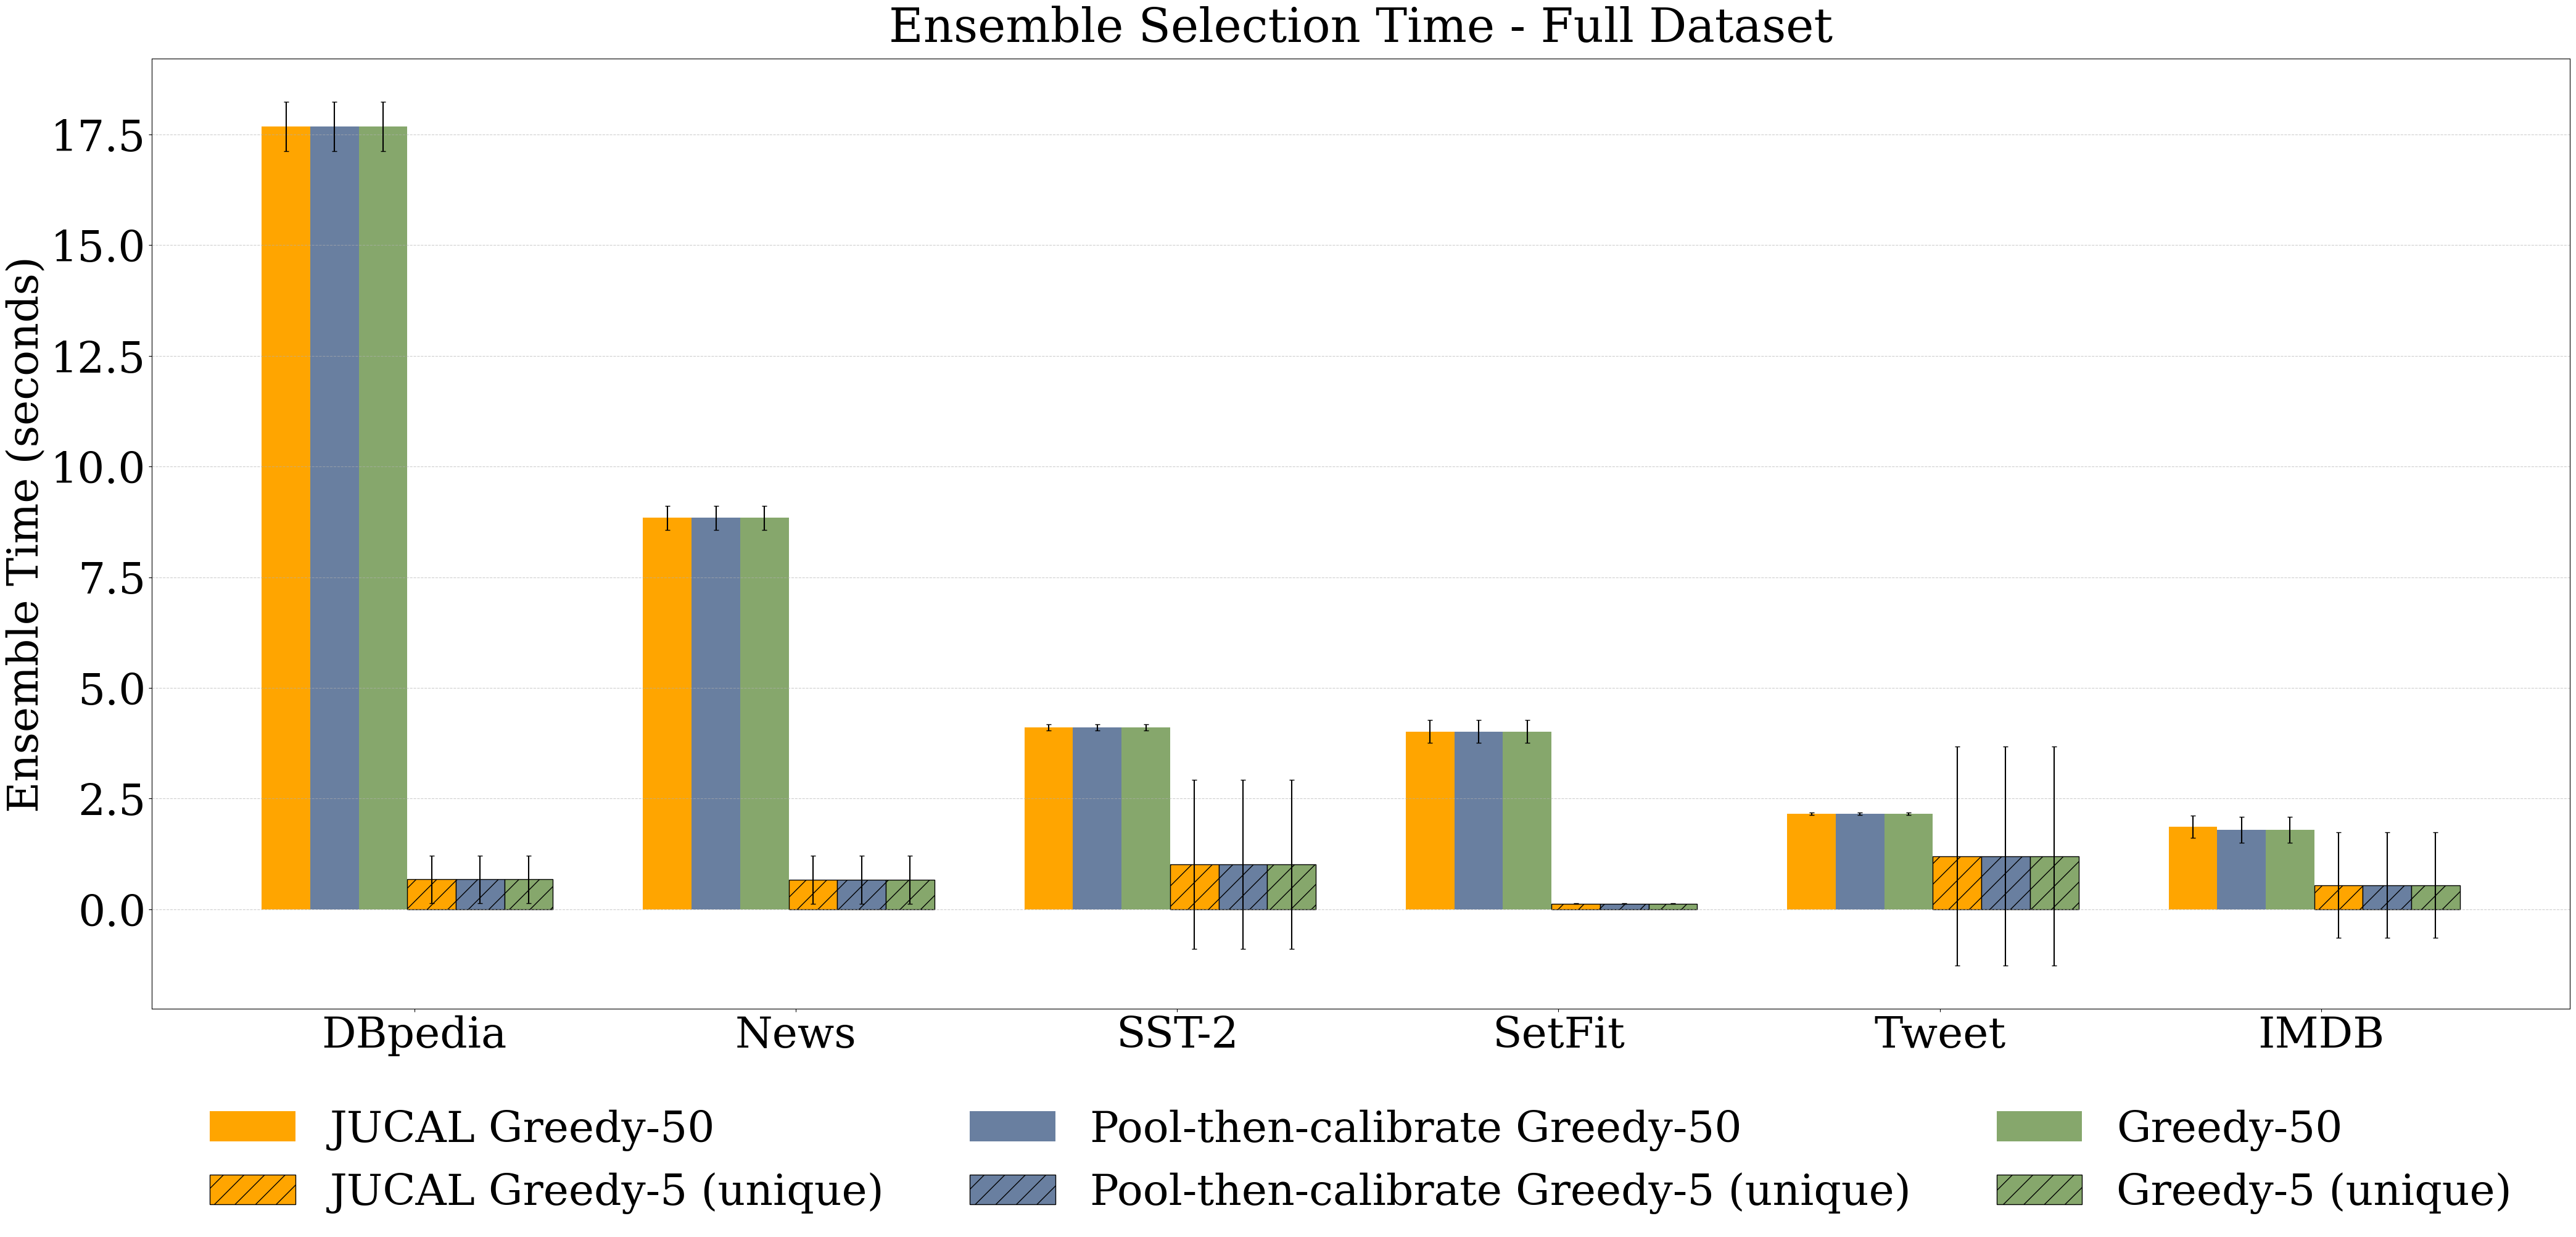

In [9]:
# Compute statistics for full dataset
df_extended_ensemble_time = df_extended[['dataset', 'seed', 'ensemble_type', 'ensemble_time']].copy()
df_extended_calib_time = df_extended[['dataset', 'seed', 'ensemble_type', 'calibration_time']].copy()

# Compute stats
df_ensemble_time_stats = compute_stats(df_extended_ensemble_time, 'ensemble_time')
df_calib_time_stats = compute_stats(df_extended_calib_time, 'calibration_time')

# Plot ensemble time for full dataset
plot_time_metric(
    df_ensemble_time_stats,
    'Ensemble Time (seconds)',
    title='Ensemble Selection Time - Full Dataset',
    filename=None,  # Set to 'figures/extended_ensemble_time.pdf' to save
    ylim=None,  # Let it auto-scale
    logscale=False,
    order=desired_order,
    ensemble_labels=ensemble_labels,
    colors=colors,
    striped_methods=striped_methods
)

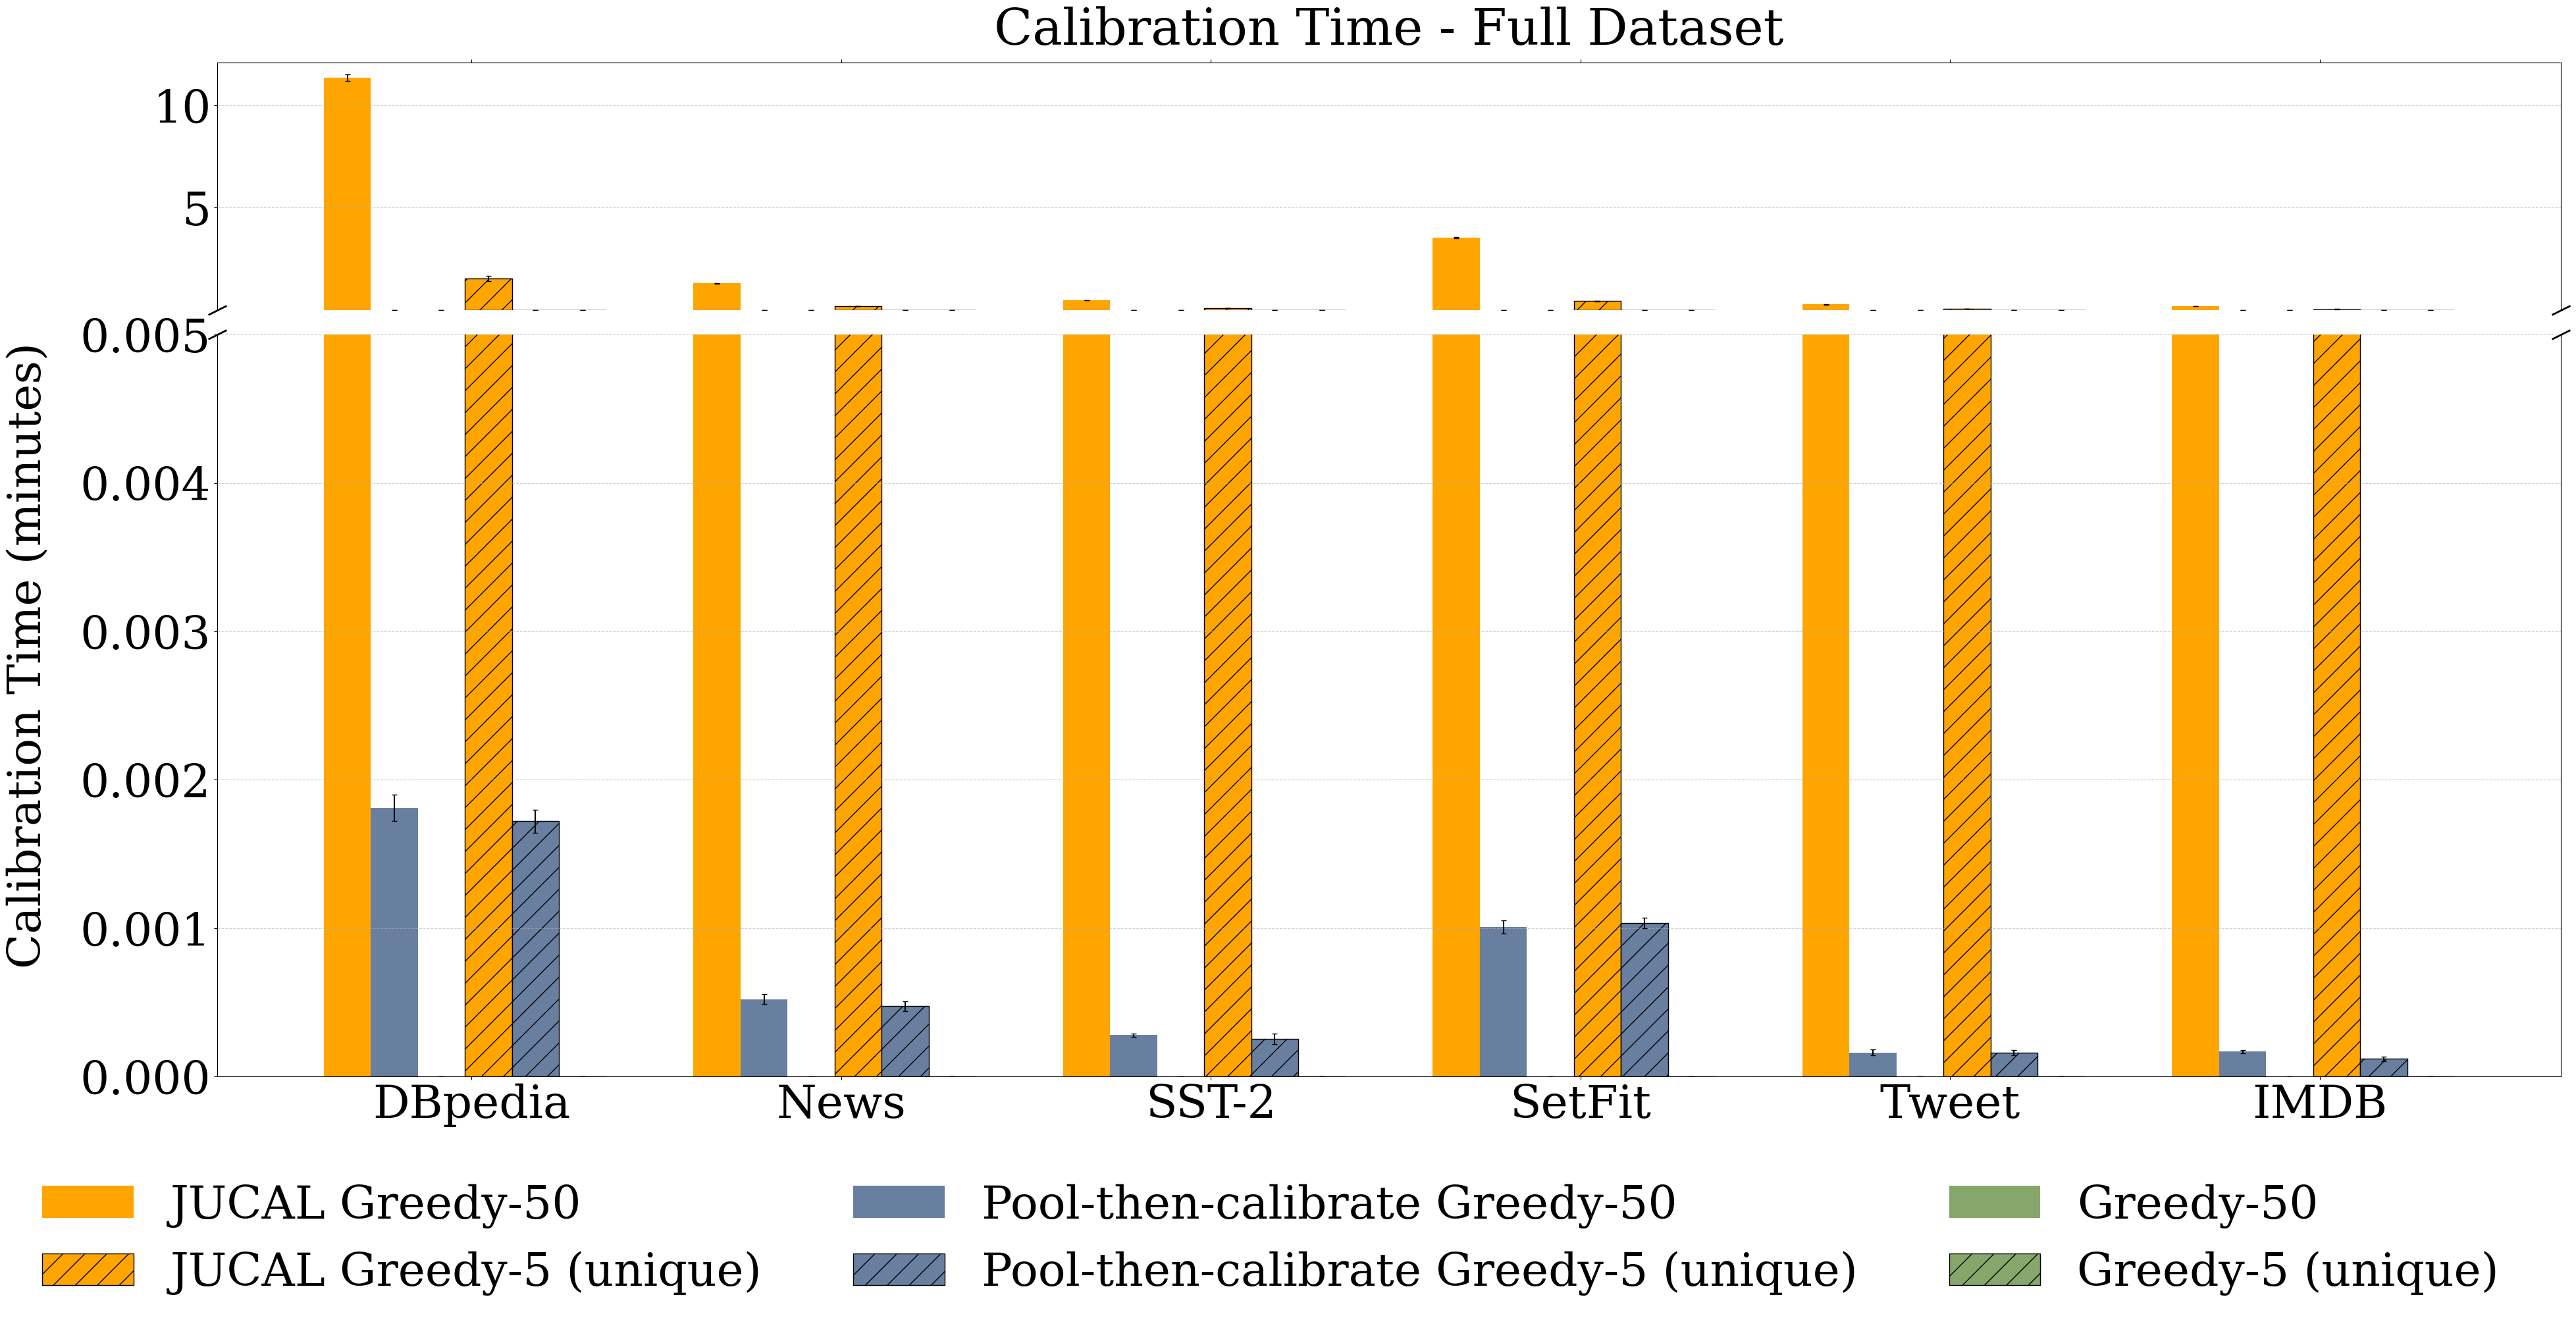

In [10]:
# Convert calibration time to minutes for full dataset
df_extended_calib_time_minutes = df_extended[['dataset', 'seed', 'ensemble_type', 'calibration_time']].copy()
df_extended_calib_time_minutes['calibration_time'] = df_extended_calib_time_minutes['calibration_time'] / 60.0  # Convert to minutes

# Compute stats for calibration time in minutes
df_calib_time_minutes_stats = compute_stats(df_extended_calib_time_minutes, 'calibration_time')

# Plot calibration time for full dataset with broken y-axis (in minutes)
plot_calibration_time_broken_axis(
    df_calib_time_minutes_stats,
    'Calibration Time (minutes)',
    title='Calibration Time - Full Dataset',
    filename=None,  # Set to 'figures/extended_calibration_time.pdf' to save
    order=desired_order,
    ensemble_labels=ensemble_labels,
    colors=colors,
    striped_methods=striped_methods,
    break_position=(0.005, 0.01),  # Adjusted for minutes
    height_ratio=(1, 3)
)

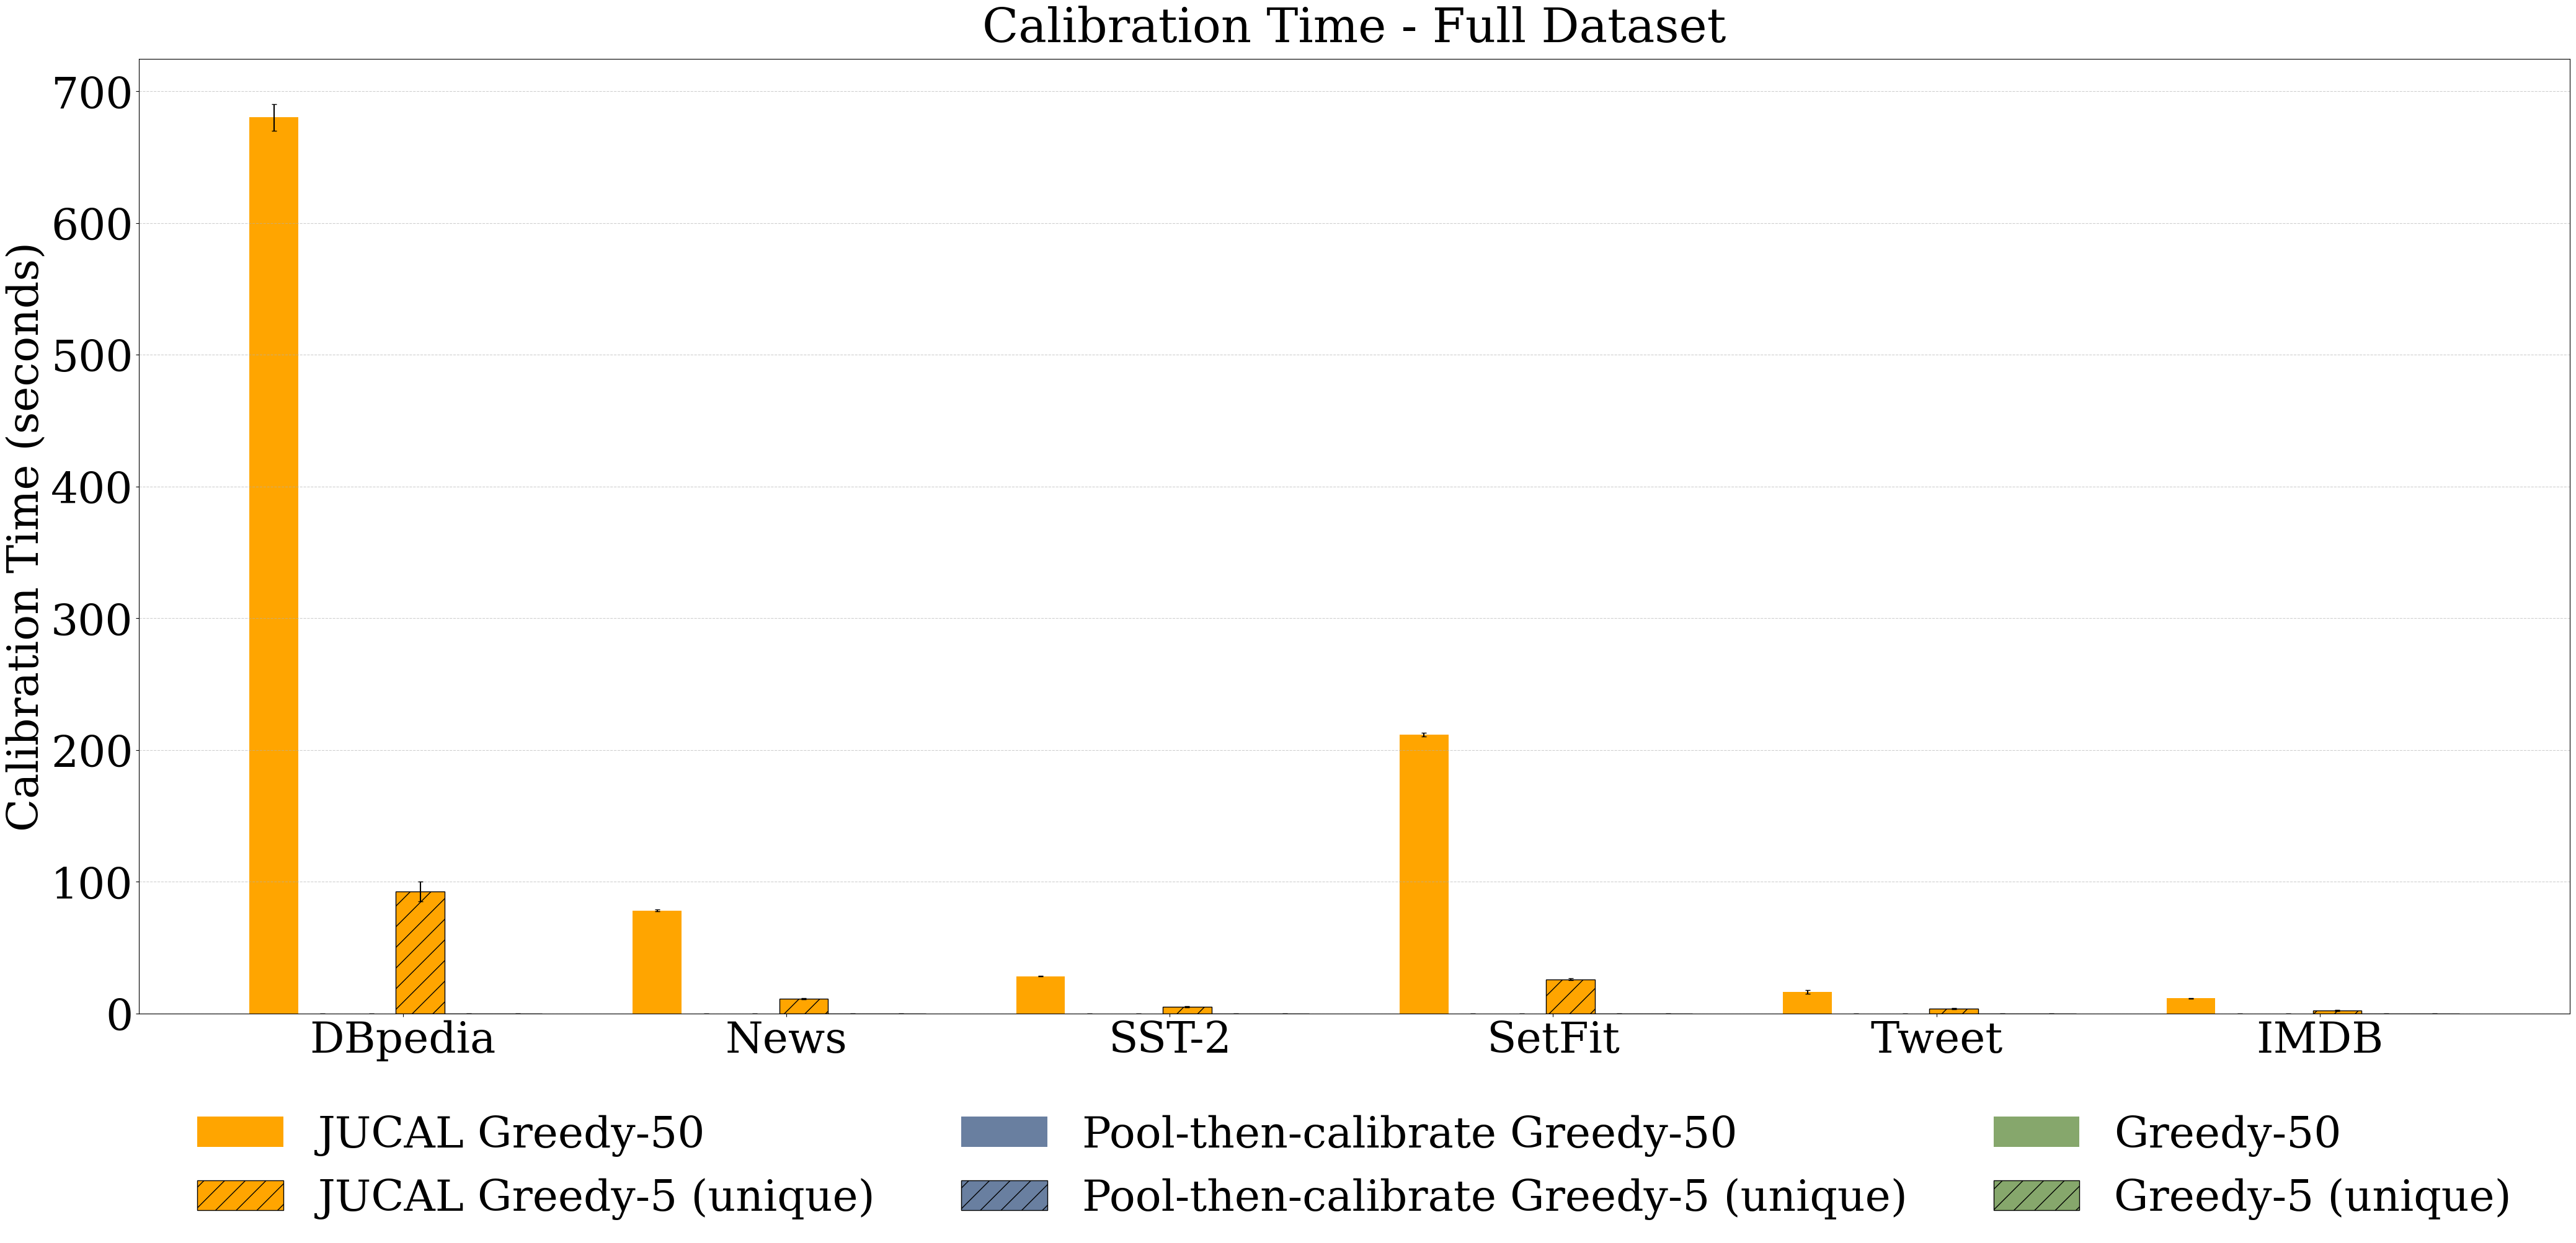

In [11]:
# Plot calibration time for Full Dataset
plot_time_metric(
    df_calib_time_stats,
    'Calibration Time (seconds)',
    title='Calibration Time - Full Dataset',
    filename=None,  # Set to 'figures/extended_calibration_time.pdf' to save
    ylim=None,  # Let it auto-scale
    logscale=False,
    order=desired_order,
    ensemble_labels=ensemble_labels,
    colors=colors,
    striped_methods=striped_methods
)

## Mini Dataset Time Analysis

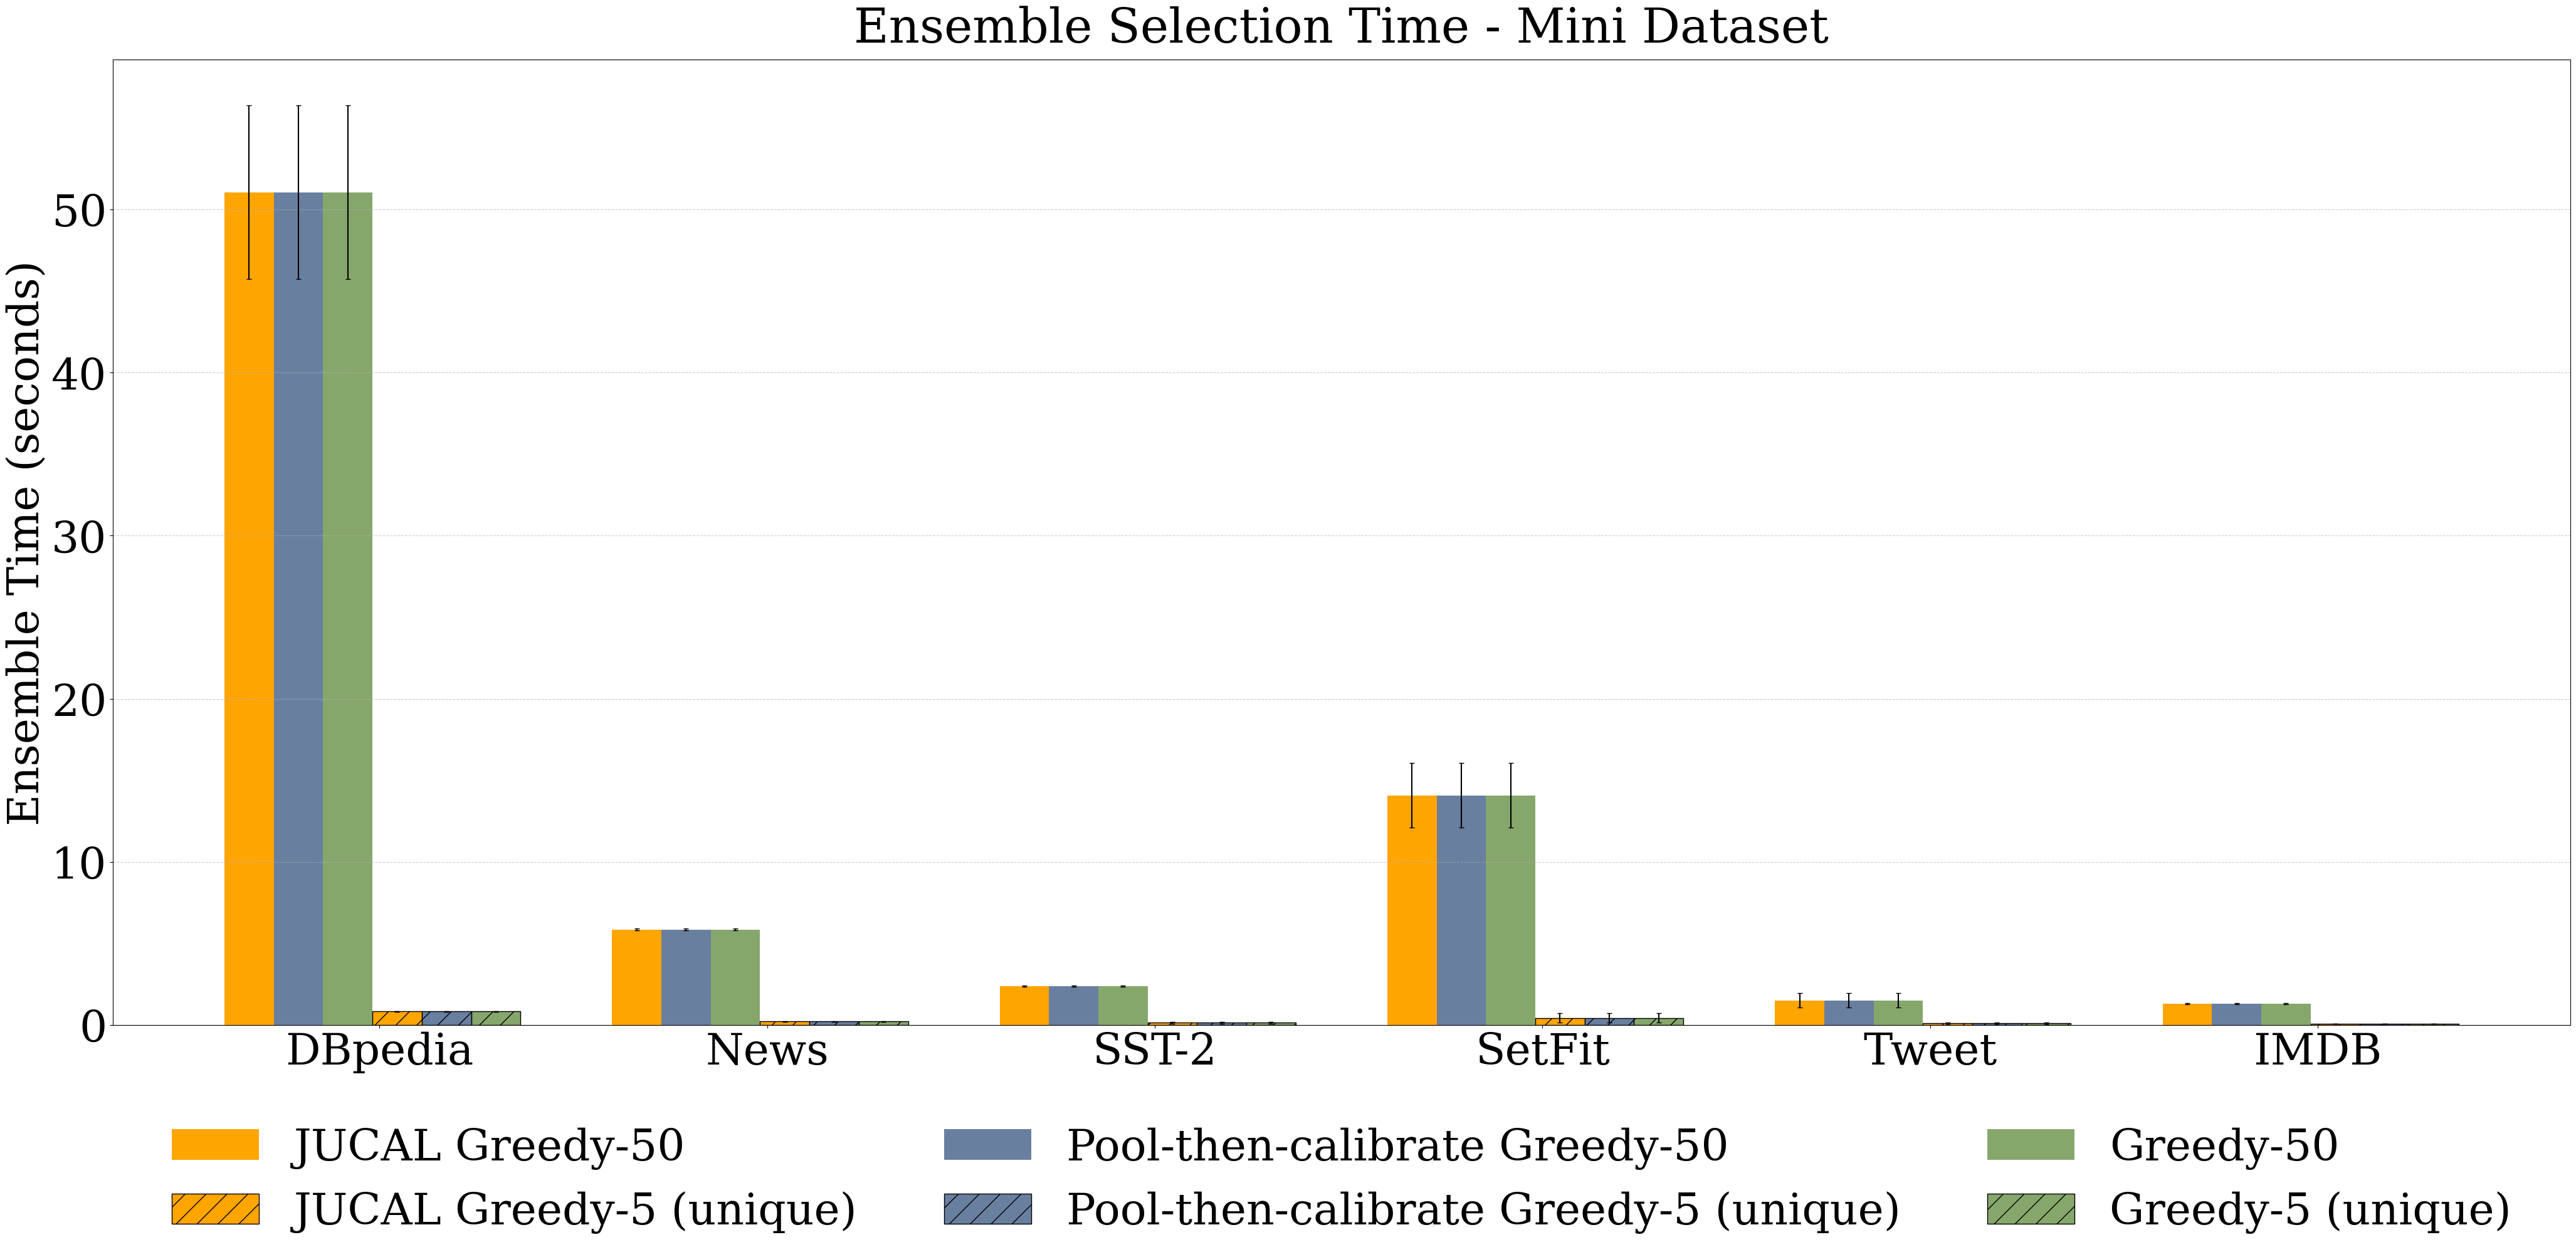

In [12]:
# Compute statistics for mini dataset - ensemble time
df_mini_ensemble_time = df_mini[['dataset', 'seed', 'ensemble_type', 'ensemble_time']].copy()

# Compute stats
df_mini_ensemble_time_stats = compute_stats(df_mini_ensemble_time, 'ensemble_time')

# Plot ensemble time for mini dataset
plot_time_metric(
    df_mini_ensemble_time_stats,
    'Ensemble Time (seconds)',
    title='Ensemble Selection Time - Mini Dataset',
    filename=None,  # Set to 'figures/mini_ensemble_time.pdf' to save
    ylim=None,
    logscale=False,
    order=desired_order,
    ensemble_labels=ensemble_labels,
    colors=colors,
    striped_methods=striped_methods
)

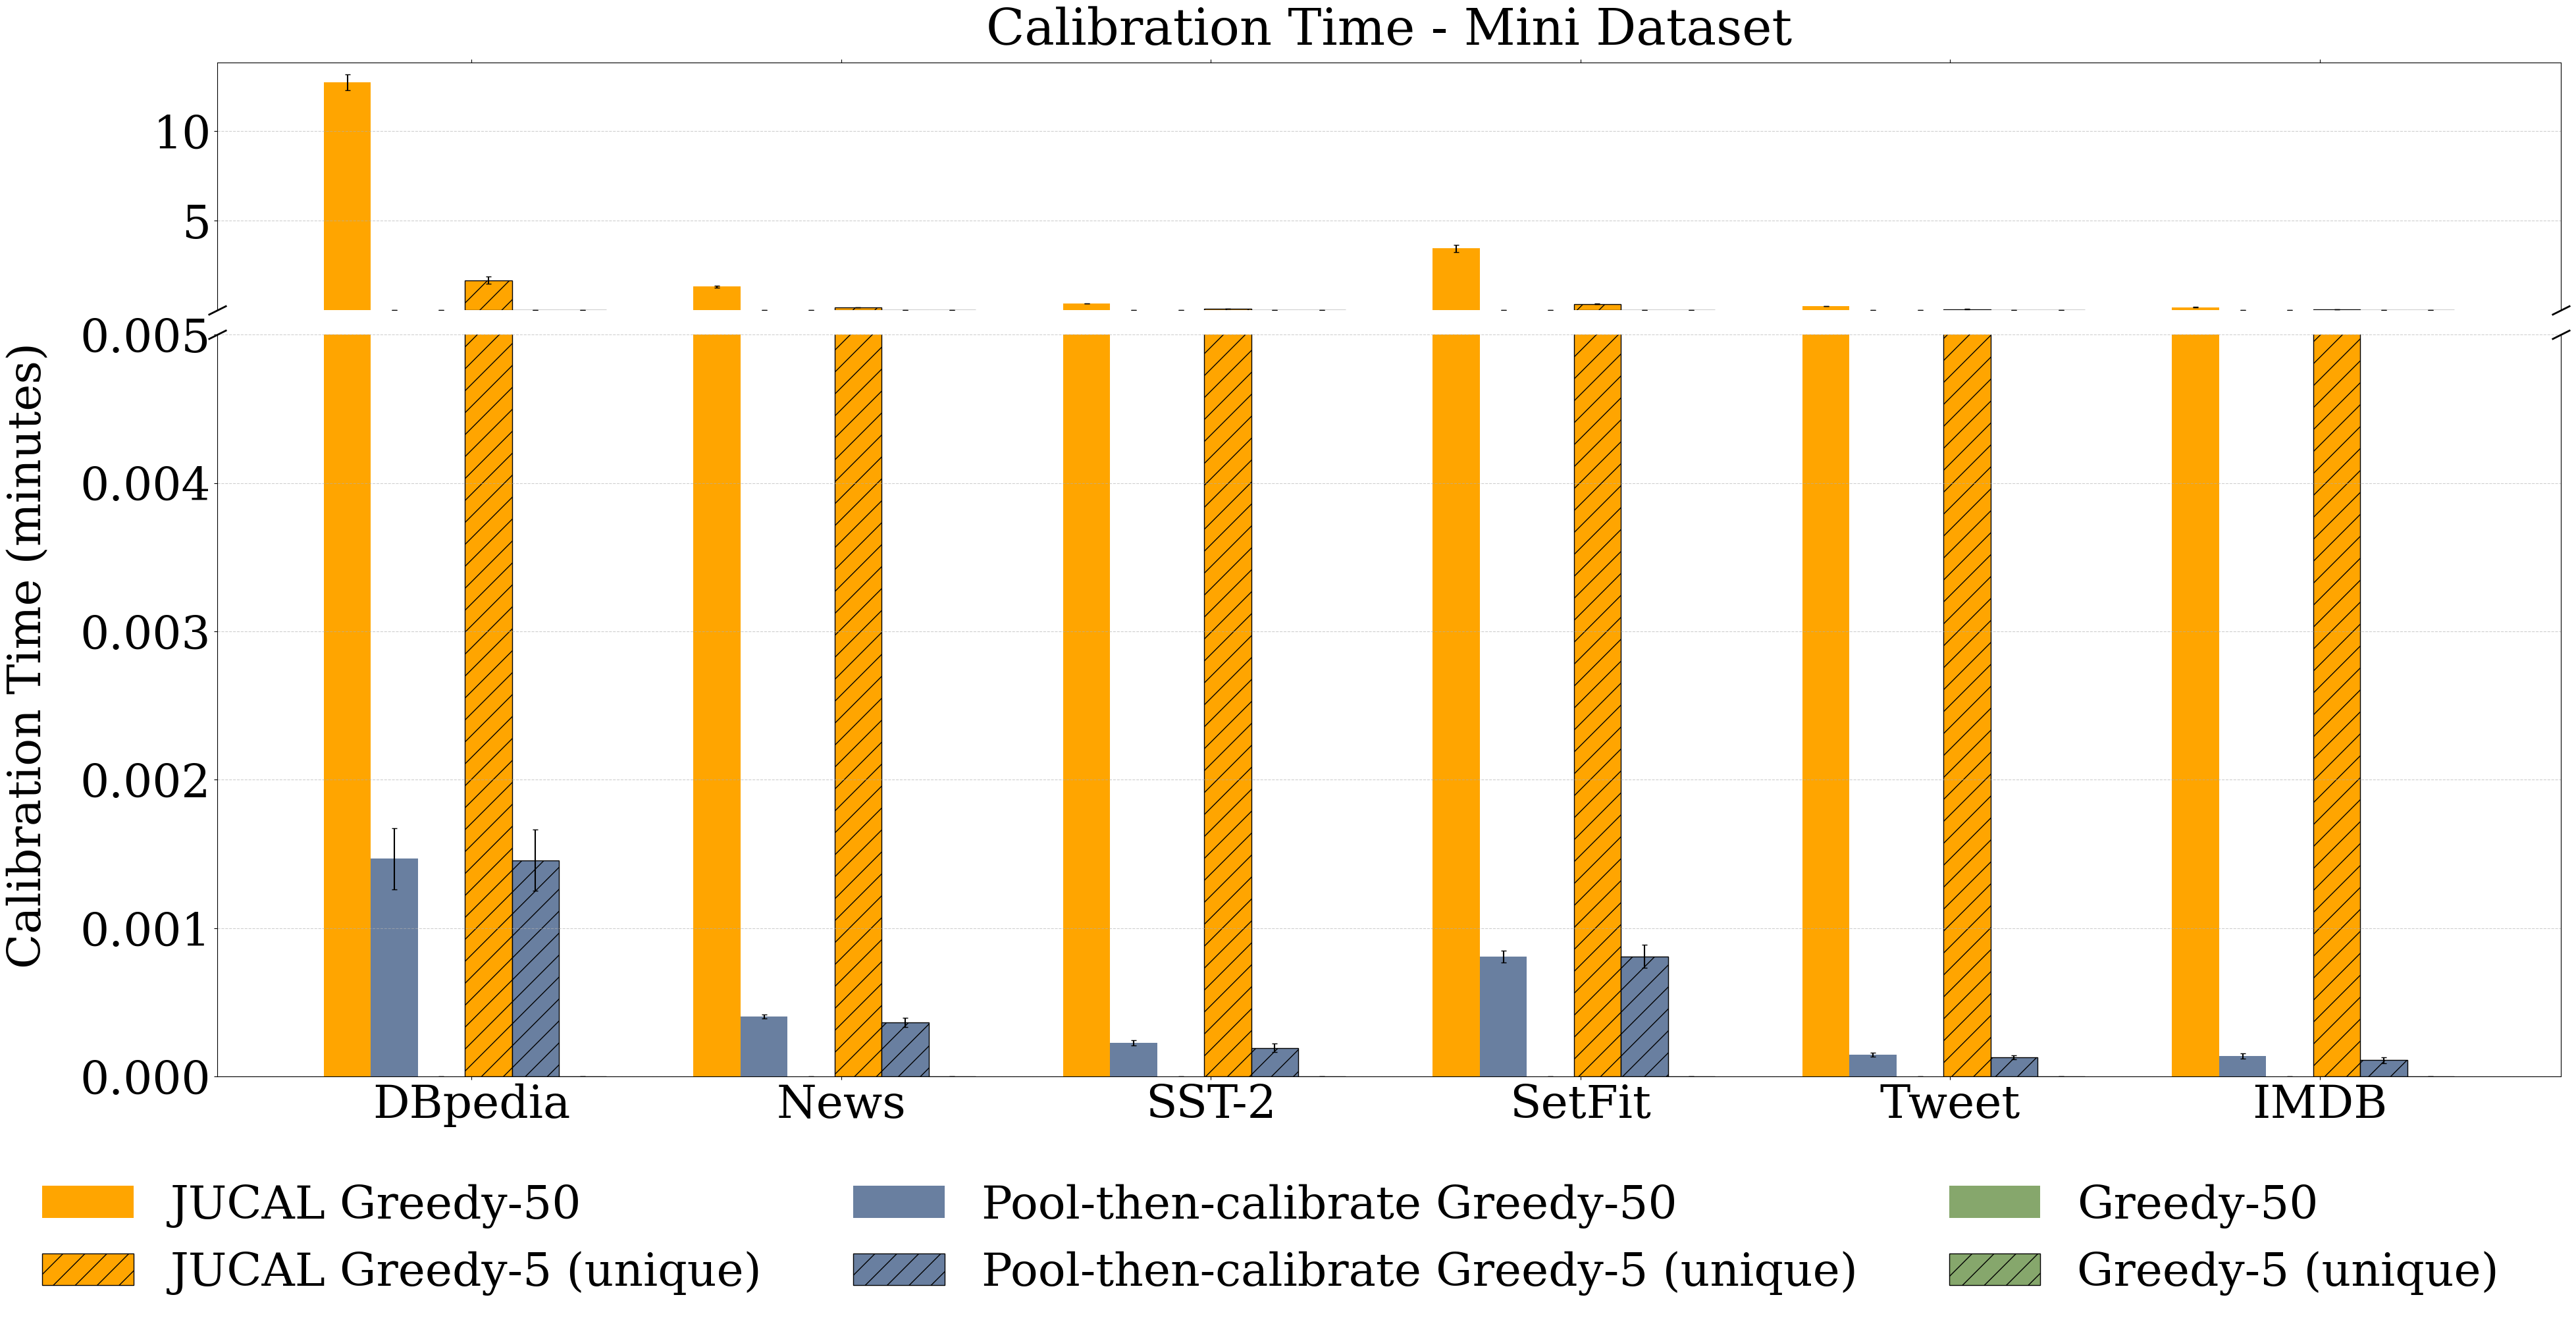

In [13]:
# Convert calibration time to minutes for mini dataset
df_mini_calib_time_minutes = df_mini[['dataset', 'seed', 'ensemble_type', 'calibration_time']].copy()
df_mini_calib_time_minutes['calibration_time'] = df_mini_calib_time_minutes['calibration_time'] / 60.0  # Convert to minutes

# Compute stats for calibration time in minutes
df_mini_calib_time_minutes_stats = compute_stats(df_mini_calib_time_minutes, 'calibration_time')

# Plot calibration time for mini dataset with broken y-axis (in minutes)
plot_calibration_time_broken_axis(
    df_mini_calib_time_minutes_stats,
    'Calibration Time (minutes)',
    title='Calibration Time - Mini Dataset',
    filename=None,  # Set to 'figures/mini_calibration_time.pdf' to save
    order=desired_order,
    ensemble_labels=ensemble_labels,
    colors=colors,
    striped_methods=striped_methods,
    break_position=(0.005, 0.01),  # Adjusted for minutes
    height_ratio=(1, 3)
)

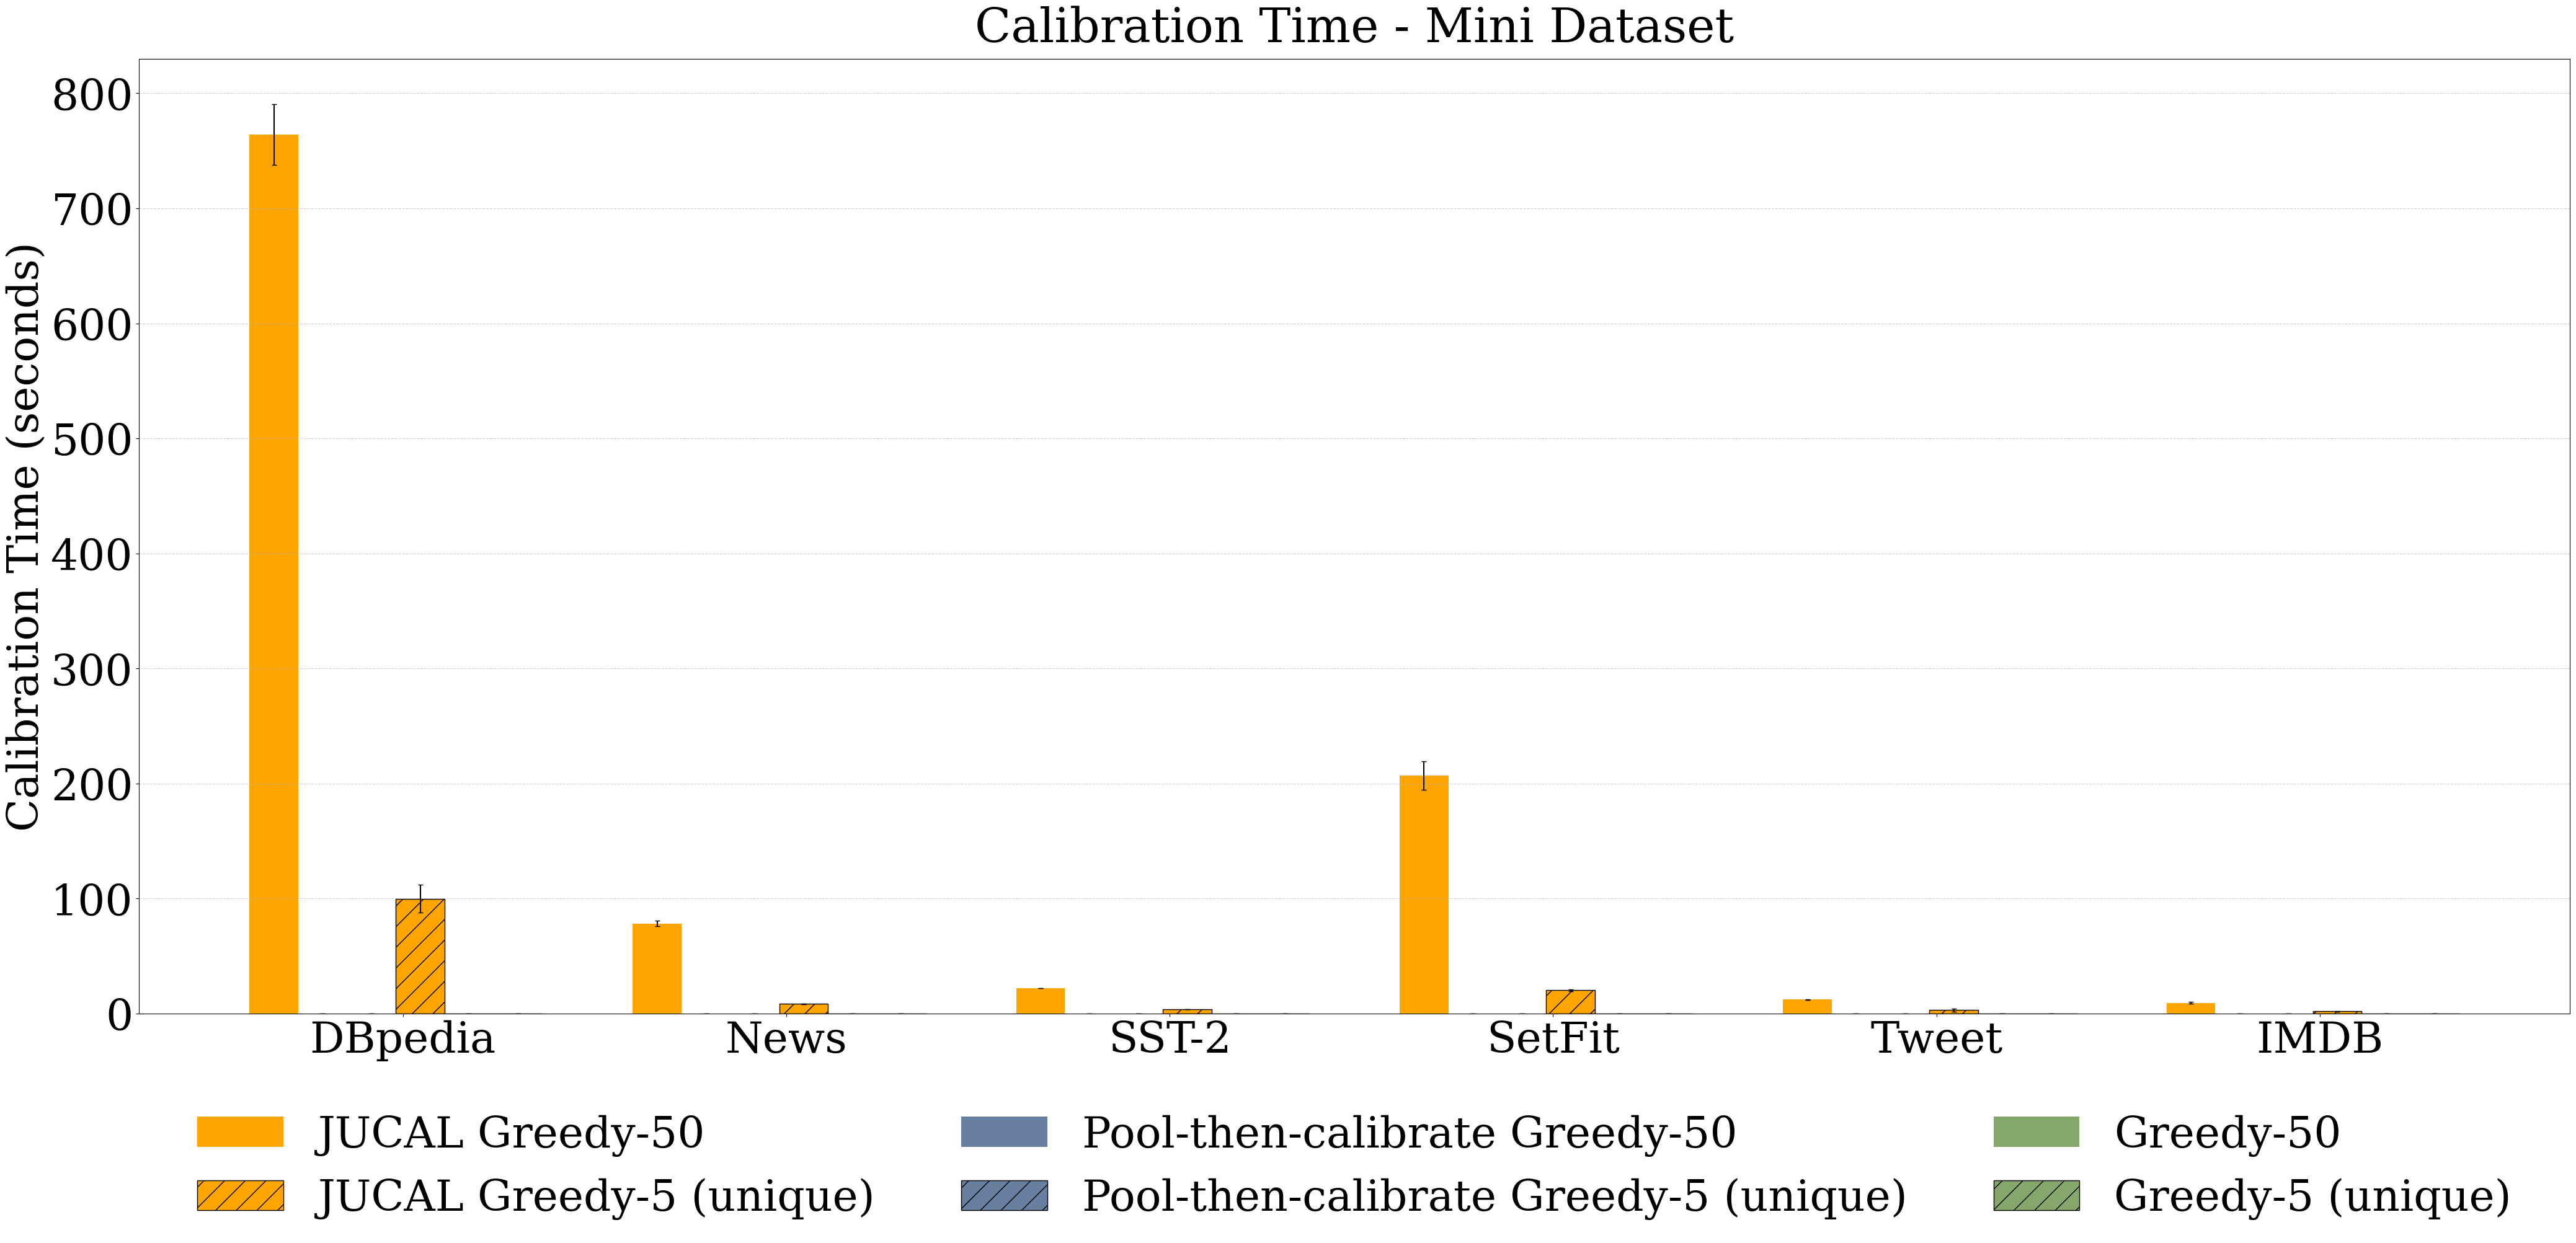

In [14]:
# Compute calibration time stats in seconds for mini dataset
df_mini_calib_time = df_mini[['dataset', 'seed', 'ensemble_type', 'calibration_time']].copy()

# Compute stats
df_mini_calib_time_stats = compute_stats(df_mini_calib_time, 'calibration_time')

# Plot calibration time for mini dataset
plot_time_metric(
    df_mini_calib_time_stats,
    'Calibration Time (seconds)',
    title='Calibration Time - Mini Dataset',
    filename=None,  # Set to 'figures/mini_calibration_time.pdf' to save
    ylim=None,
    logscale=False,
    order=desired_order,
    ensemble_labels=ensemble_labels,
    colors=colors,
    striped_methods=striped_methods
)

## Summary Statistics

In [15]:
# Create comprehensive table with all datasets, types, and timing information
print("=" * 150)
print("COMPREHENSIVE TIMING TABLE - All Datasets with FTC (Full) and Mini Results")
print("=" * 150)

# Add dataset type to both dataframes
df_extended_table = df_extended.copy()
df_extended_table['Type'] = 'FTC'

df_mini_table = df_mini.copy()
df_mini_table['Type'] = 'Mini'

# Combine both dataframes
df_all = pd.concat([df_extended_table, df_mini_table], ignore_index=True)

# Create comprehensive statistics table
results = []

for dataset in desired_order:
    for ensemble_method in ensemble_labels:
        # Get FTC stats
        ftc_data = df_all[(df_all['dataset'] == dataset) & 
                         (df_all['Type'] == 'FTC') & 
                         (df_all['ensemble_type'] == ensemble_method)]
        
        if len(ftc_data) > 0:
            ftc_ensemble_mean = ftc_data['ensemble_time'].mean()
            ftc_ensemble_std = ftc_data['ensemble_time'].std()
            ftc_calib_mean = ftc_data['calibration_time'].mean()
            ftc_calib_std = ftc_data['calibration_time'].std()
            
            results.append({
                'Dataset': dataset,
                'Type': 'FTC',
                'Ensemble Method': ensemble_method,
                'Ensemble Time (s)': f"{ftc_ensemble_mean:.4f} ± {ftc_ensemble_std:.4f}",
                'Calibration Time (s)': f"{ftc_calib_mean:.4f} ± {ftc_calib_std:.4f}"
            })
        
        # Get Mini stats
        mini_data = df_all[(df_all['dataset'] == dataset) & 
                          (df_all['Type'] == 'Mini') & 
                          (df_all['ensemble_type'] == ensemble_method)]
        
        if len(mini_data) > 0:
            mini_ensemble_mean = mini_data['ensemble_time'].mean()
            mini_ensemble_std = mini_data['ensemble_time'].std()
            mini_calib_mean = mini_data['calibration_time'].mean()
            mini_calib_std = mini_data['calibration_time'].std()
            
            results.append({
                'Dataset': dataset,
                'Type': 'Mini',
                'Ensemble Method': ensemble_method,
                'Ensemble Time (s)': f"{mini_ensemble_mean:.4f} ± {mini_ensemble_std:.4f}",
                'Calibration Time (s)': f"{mini_calib_mean:.4f} ± {mini_calib_std:.4f}"
            })

# Create DataFrame
results_df = pd.DataFrame(results)

# Print table grouped by dataset
for dataset in desired_order:
    dataset_results = results_df[results_df['Dataset'] == dataset]
    if len(dataset_results) > 0:
        print(f"\n{dataset}:")
        print("-" * 150)
        # Print without the Dataset column since it's in the header
        print(dataset_results[['Type', 'Ensemble Method', 'Ensemble Time (s)', 'Calibration Time (s)']].to_string(index=False))

print("\n" + "=" * 150)

COMPREHENSIVE TIMING TABLE - All Datasets with FTC (Full) and Mini Results

DBpedia:
------------------------------------------------------------------------------------------------------------------------------------------------------
Type                       Ensemble Method Ensemble Time (s) Calibration Time (s)
 FTC                       JUCAL Greedy-50  17.6798 ± 0.5566    680.2392 ± 9.9481
Mini                       JUCAL Greedy-50  51.0481 ± 5.3242   764.0273 ± 26.3293
 FTC         Pool-then-calibrate Greedy-50  17.6798 ± 0.5566      0.1085 ± 0.0054
Mini         Pool-then-calibrate Greedy-50  51.0481 ± 5.3242      0.0880 ± 0.0124
 FTC                             Greedy-50  17.6798 ± 0.5566      0.0000 ± 0.0000
Mini                             Greedy-50  51.0481 ± 5.3242      0.0000 ± 0.0000
 FTC               JUCAL Greedy-5 (unique)   0.6779 ± 0.5347     92.5821 ± 7.4349
Mini               JUCAL Greedy-5 (unique)   0.8412 ± 0.0215    99.8790 ± 12.2445
 FTC Pool-then-calibrate G

## JUCAL-Only Time Analysis Table

In [17]:
# Create JUCAL-only timing table with all datasets (Full/Mini) 
print("=" * 120)
print("JUCAL METHODS TIME ANALYSIS - All Datasets Full vs Mini")
print("=" * 120)

# Filter for JUCAL methods only (remove 'unique' from name)
jucal_methods = ['JUCAL Greedy-50', 'JUCAL Greedy-5 (unique)']
jucal_method_names = ['JUCAL Greedy-50', 'JUCAL Greedy-5']  # Clean names without 'unique'

# Create focused JUCAL results for all datasets
jucal_all_results = []

for dataset in desired_order:
    # Full dataset results
    for i, ensemble_method in enumerate(jucal_methods):
        ftc_data = df_all[(df_all['dataset'] == dataset) & 
                         (df_all['Type'] == 'FTC') & 
                         (df_all['ensemble_type'] == ensemble_method)]
        
        if len(ftc_data) > 0:
            ftc_ensemble_mean = ftc_data['ensemble_time'].mean()
            ftc_ensemble_std = ftc_data['ensemble_time'].std()
            ftc_calib_mean = ftc_data['calibration_time'].mean()
            ftc_calib_std = ftc_data['calibration_time'].std()
            
            jucal_all_results.append({
                'Dataset': f"{dataset} Full",
                'Ensemble Method': jucal_method_names[i],
                'Ensemble Time (s)': f"{ftc_ensemble_mean:.4f} ± {ftc_ensemble_std:.4f}",
                'Calibration Time (s)': f"{ftc_calib_mean:.4f} ± {ftc_calib_std:.4f}"
            })
    
    # Mini dataset results
    for i, ensemble_method in enumerate(jucal_methods):
        mini_data = df_all[(df_all['dataset'] == dataset) & 
                          (df_all['Type'] == 'Mini') & 
                          (df_all['ensemble_type'] == ensemble_method)]
        
        if len(mini_data) > 0:
            mini_ensemble_mean = mini_data['ensemble_time'].mean()
            mini_ensemble_std = mini_data['ensemble_time'].std()
            mini_calib_mean = mini_data['calibration_time'].mean()
            mini_calib_std = mini_data['calibration_time'].std()
            
            jucal_all_results.append({
                'Dataset': f"{dataset} Mini",
                'Ensemble Method': jucal_method_names[i],
                'Ensemble Time (s)': f"{mini_ensemble_mean:.4f} ± {mini_ensemble_std:.4f}",
                'Calibration Time (s)': f"{mini_calib_mean:.4f} ± {mini_calib_std:.4f}"
            })

# Create DataFrame for all JUCAL results
jucal_all_df = pd.DataFrame(jucal_all_results)

print(jucal_all_df.to_string(index=False))
print("\n" + "=" * 120)

JUCAL METHODS TIME ANALYSIS - All Datasets Full vs Mini
     Dataset Ensemble Method Ensemble Time (s) Calibration Time (s)
DBpedia Full JUCAL Greedy-50  17.6798 ± 0.5566    680.2392 ± 9.9481
DBpedia Full  JUCAL Greedy-5   0.6779 ± 0.5347     92.5821 ± 7.4349
DBpedia Mini JUCAL Greedy-50  51.0481 ± 5.3242   764.0273 ± 26.3293
DBpedia Mini  JUCAL Greedy-5   0.8412 ± 0.0215    99.8790 ± 12.2445
   News Full JUCAL Greedy-50   8.8411 ± 0.2699     78.3229 ± 0.8914
   News Full  JUCAL Greedy-5   0.6653 ± 0.5407     11.2228 ± 0.3444
   News Mini JUCAL Greedy-50   5.8553 ± 0.0659     78.2003 ± 2.4816
   News Mini  JUCAL Greedy-5   0.2189 ± 0.0079      8.3616 ± 0.4244
  SST-2 Full JUCAL Greedy-50   4.1086 ± 0.0714     28.3639 ± 0.3088
  SST-2 Full  JUCAL Greedy-5   1.0158 ± 1.9079      5.2648 ± 0.3565
  SST-2 Mini JUCAL Greedy-50   2.3958 ± 0.0370     21.9965 ± 0.0998
  SST-2 Mini  JUCAL Greedy-5   0.1430 ± 0.0531      3.7017 ± 0.0385
 SetFit Full JUCAL Greedy-50   4.0146 ± 0.2551    211.6587 ±